# Creating and Backtesting MACD Strategies

## Getting the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
data = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")

In [3]:
data

,BTC,ETH,LTC,DASH
Date,,,,
2016-01-01,434.334015,0.948024,3.508980,3.377020
2016-01-02,433.437988,0.937124,3.502160,3.280160
2016-01-03,430.010986,0.971905,3.483070,3.240140
2016-01-04,433.091003,0.954480,3.495390,3.318990
2016-01-05,431.959991,0.950176,3.469670,3.325760
...,...,...,...,...
2021-02-26,46339.761719,1446.033691,170.398148,206.701660
2021-02-27,46188.453125,1459.973145,172.100449,211.656204
2021-02-28,45137.769531,1416.048950,164.927170,196.271896


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1884 entries, 2016-01-01 to 2021-03-02
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     1884 non-null   float64
 1   ETH     1884 non-null   float64
 2   LTC     1884 non-null   float64
 3   DASH    1884 non-null   float64
dtypes: float64(4)
memory usage: 73.6 KB


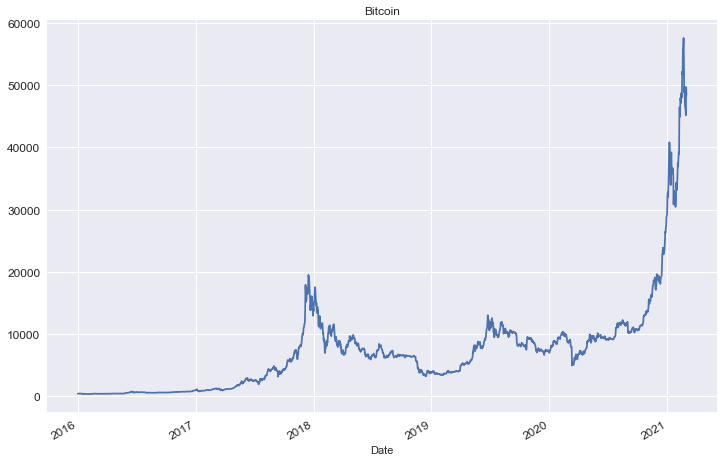

In [5]:
data.BTC.plot(figsize = (12, 8), title = "Bitcoin", fontsize = 12)
plt.show()

In [6]:
data=data.drop(['ETH', 'LTC', 'DASH'], axis=1)
data

,BTC
Date,
2016-01-01,434.334015
2016-01-02,433.437988
2016-01-03,430.010986
2016-01-04,433.091003
2016-01-05,431.959991
...,...
2021-02-26,46339.761719
2021-02-27,46188.453125
2021-02-28,45137.769531


## Using the MACDBacktester Class

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [8]:
pd.read_csv("cryptos.csv")

,Date,BTC,ETH,LTC,DASH
0,2016-01-01,434.334015,0.948024,3.508980,3.377020
1,2016-01-02,433.437988,0.937124,3.502160,3.280160
2,2016-01-03,430.010986,0.971905,3.483070,3.240140
3,2016-01-04,433.091003,0.954480,3.495390,3.318990
4,2016-01-05,431.959991,0.950176,3.469670,3.325760
...,...,...,...,...,...
1879,2021-02-26,46339.761719,1446.033691,170.398148,206.701660
1880,2021-02-27,46188.453125,1459.973145,172.100449,211.656204
1881,2021-02-28,45137.769531,1416.048950,164.927170,196.271896
1882,2021-03-01,49631.242188,1564.707642,175.237900,223.279999


In [9]:
class MACDBacktester(): 
    ''' Class for the vectorized backtesting of MACD-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    signal_mw: int
        time window is days for MACD Signal 
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets new MACD parameter(s)
        
    test_strategy:
        runs the backtest for the MACD-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates MACD parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the three MACD parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, signal_mw, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.signal_mw = signal_mw
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "MACDBacktester(symbol = {}, MACD({}, {}, {}), start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.signal_mw, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("cryptos.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
        raw["MACD"] = raw.EMA_S - raw.EMA_L
        raw["MACD_Signal"] = raw.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean() 
        self.data = raw
      
        
    def set_parameters(self, EMA_S = None, EMA_L = None, signal_mw = None):
        ''' Updates MACD parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean()
            self.data["MACD"] = self.data.EMA_S - self.data.EMA_L
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            self.data["MACD"] = self.data.EMA_S - self.data.EMA_L
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
        if signal_mw is not None:
            self.signal_mw = signal_mw
            self.data["MACD_Signal"] = self.data.MACD.ewm(span = self.signal_mw, min_periods = self.signal_mw).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["MACD"] > data["MACD_Signal"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | MACD ({}, {}, {}) | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.signal_mw, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, MACD):
        ''' Updates MACD parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        MACD: tuple
            MACD parameter tuple
        '''
        self.set_parameters(int(MACD[0]), int(MACD[1]), int(MACD[2]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA_S_range, EMA_L_range, signal_mw_range):
        ''' Finds global maximum given the MACD parameter ranges.

        Parameters
        ==========
        EMA_S_range, EMA_L_range, signal_mw_range : tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA_S_range, EMA_L_range, signal_mw_range), finish=None)
        return opt, -self.update_and_run(opt)

In [10]:
tester = MACDBacktester("BTC", EMA_S = 12, EMA_L = 26, signal_mw = 9,
              start = "2016-01-01", end = "2021-03-01", tc = 0)

In [11]:
tester

MACDBacktester(symbol = BTC, MACD(12, 26, 9), start = 2016-01-01, end = 2021-03-01)

In [12]:
tester.data

,price,returns,EMA_S,EMA_L,MACD,MACD_Signal
Date,,,,,,
2016-01-01,434.334015,NaN,NaN,NaN,NaN,NaN
2016-01-02,433.437988,-0.002065,NaN,NaN,NaN,NaN
2016-01-03,430.010986,-0.007938,NaN,NaN,NaN,NaN
2016-01-04,433.091003,0.007137,NaN,NaN,NaN,NaN
2016-01-05,431.959991,-0.002615,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-02-25,47093.851562,-0.053970,50212.446060,46673.080398,3539.365662,4271.374549
2021-02-26,46339.761719,-0.016142,49616.648469,46648.390125,2968.258344,4010.751308
2021-02-27,46188.453125,-0.003271,49089.233801,46614.320718,2474.913083,3703.583663


In [13]:
tester.test_strategy()

(128.09578,
 -6.061203,
 0.0    1734
 2.0     115
 Name: trades, dtype: int64)

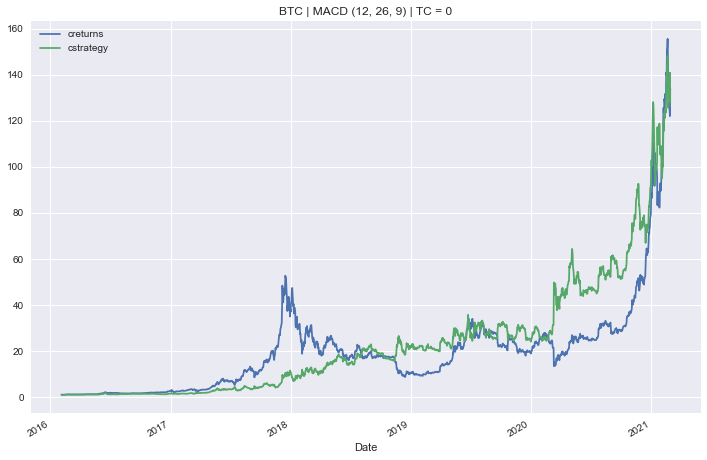

In [14]:
tester.plot_results()

In [15]:
tester.results

,price,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2016-02-04,389.593994,0.051740,382.620173,391.331374,-8.711201,-9.232670,1,-0.051740,0.0,1.053102,0.949576
2016-02-05,386.549011,-0.007846,383.226091,390.953458,-7.727367,-8.903319,1,-0.007846,0.0,1.044871,0.942154
2016-02-06,376.522003,-0.026282,382.192555,389.818659,-7.626104,-8.629026,1,-0.026282,0.0,1.017767,0.917715
2016-02-07,376.619995,0.000260,381.333735,388.785510,-7.451775,-8.379879,1,0.000260,0.0,1.018032,0.917954
2016-02-08,373.446991,-0.008461,380.118591,387.589885,-7.471295,-8.189803,1,-0.008461,0.0,1.009455,0.910220
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-25,47093.851562,-0.053970,50212.446060,46673.080398,3539.365662,4271.374549,-1,0.053970,0.0,127.298225,134.997509
2021-02-26,46339.761719,-0.016142,49616.648469,46648.390125,2968.258344,4010.751308,-1,0.016142,0.0,125.259863,137.194332
2021-02-27,46188.453125,-0.003271,49089.233801,46614.320718,2474.913083,3703.583663,-1,0.003271,0.0,124.850865,137.643767


In [16]:
#otimizar para fast, slow and signal
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([10., 24., 16.]), 623.141265)

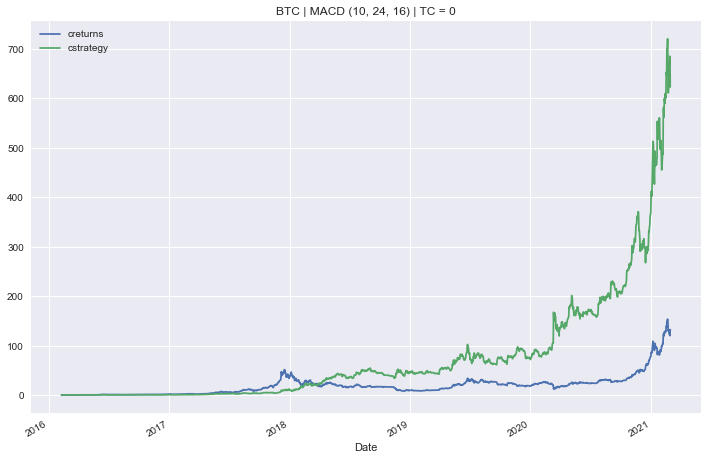

In [17]:
tester.plot_results()

In [18]:
tester.test_strategy()

(623.141265,
 490.240898,
 0.0    1743
 2.0     101
 Name: trades, dtype: int64)

__ETH-USDT__

In [19]:
tester = MACDBacktester("ETH", EMA_S = 12, EMA_L = 26, signal_mw = 9,
              start = "2016-01-01", end = "2021-03-01", tc = 0)

In [20]:
tester.test_strategy()

(507.684604,
 -111.097287,
 0.0    1723
 2.0     126
 Name: trades, dtype: int64)

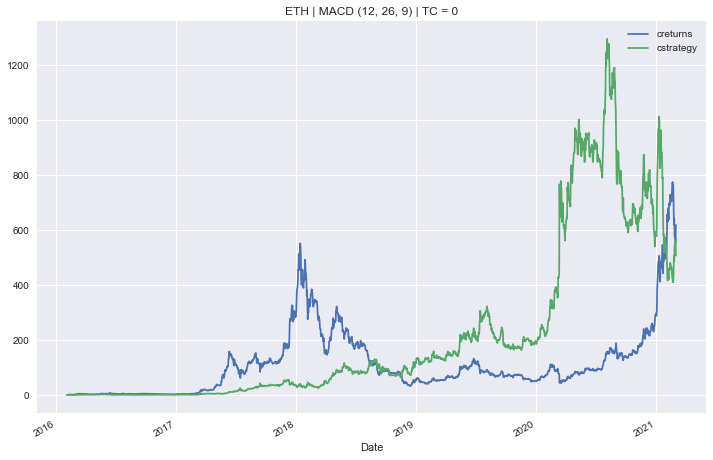

In [21]:
tester.plot_results()

In [22]:
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([19., 49., 10.]), 34172.652622)

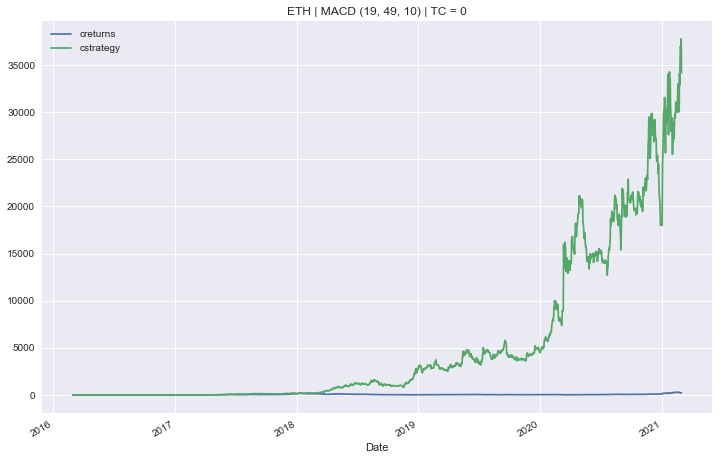

In [23]:
tester.plot_results()

In [24]:
tester.test_strategy()

(34172.652622,
 33929.150949,
 0.0    1752
 2.0      73
 Name: trades, dtype: int64)

__Optimization and Backtesting (2016 - 2019)__ ("In-Sample")

In [25]:
tester = MACDBacktester("BTC", EMA_S = 12, EMA_L = 26, signal_mw = 9,
              start = "2016-01-01", end = "2019-03-01", tc = 0)

In [26]:
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([11., 49., 11.]), 73.343192)

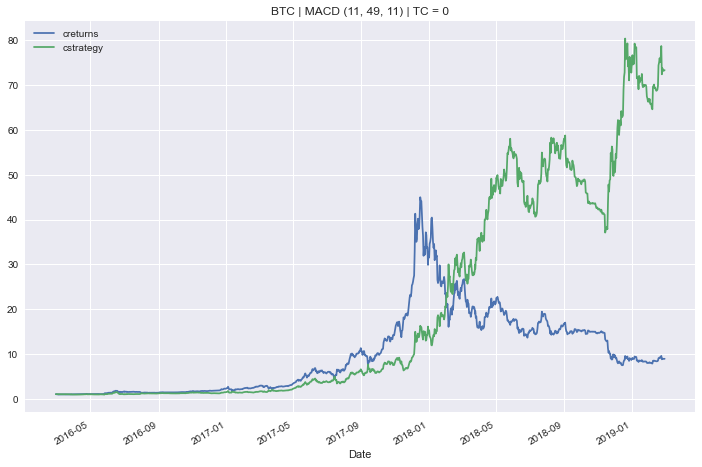

In [27]:
tester.plot_results()

In [28]:
tester.test_strategy()

(73.343192,
 64.439967,
 0.0    1039
 2.0      58
 Name: trades, dtype: int64)

__Forward Testing (2019-2021)__ ("Out-Sample")

In [29]:
forwardtester = MACDBacktester("BTC", EMA_S = 11, EMA_L = 49, signal_mw = 11,
              start = "2019-03-01", end = "2021-03-07", tc = 0)

In [30]:
forwardtester.test_strategy()

(4.872343,
 -4.281434,
 0.0    630
 2.0     40
 Name: trades, dtype: int64)

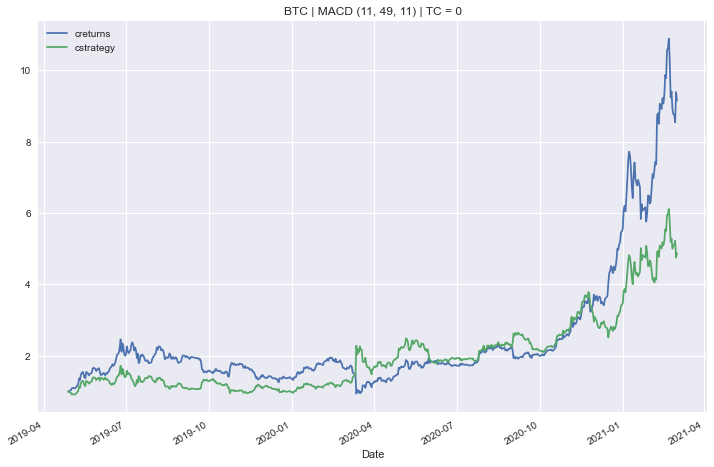

In [31]:
forwardtester.plot_results()

In [32]:
tester.test_strategy()

(73.343192,
 64.439967,
 0.0    1039
 2.0      58
 Name: trades, dtype: int64)

## Alternative Strategies and Interpretations

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [34]:
tester = MACDBacktester("BTC", EMA_S = 11, EMA_L = 49, signal_mw = 11,
              start = "2016-01-01", end = "2021-03-07", tc = 0)

In [35]:
alt = tester.data.dropna()
alt

,price,returns,EMA_S,EMA_L,MACD,MACD_Signal
Date,,,,,,
2016-02-28,433.503998,0.002275,425.657920,408.509006,17.148914,15.138328
2016-02-29,437.696991,0.009626,427.664468,409.786872,17.877595,15.652546
2016-03-01,435.122986,-0.005898,428.907572,410.891924,18.015649,16.087002
2016-03-02,423.989014,-0.025921,428.087802,411.461104,16.626699,16.184549
2016-03-03,421.651001,-0.005530,427.014991,411.902416,15.112576,15.993486
...,...,...,...,...,...,...
2021-02-26,46339.761719,-0.016142,49719.073657,41851.860042,7867.213614,9118.122726
2021-02-27,46188.453125,-0.003271,49130.636901,42025.323765,7105.313136,8782.654461
2021-02-28,45137.769531,-0.023010,48465.159006,42149.821596,6315.337410,8371.434952


__Main Strategy: MACD Signal Line Crossover__

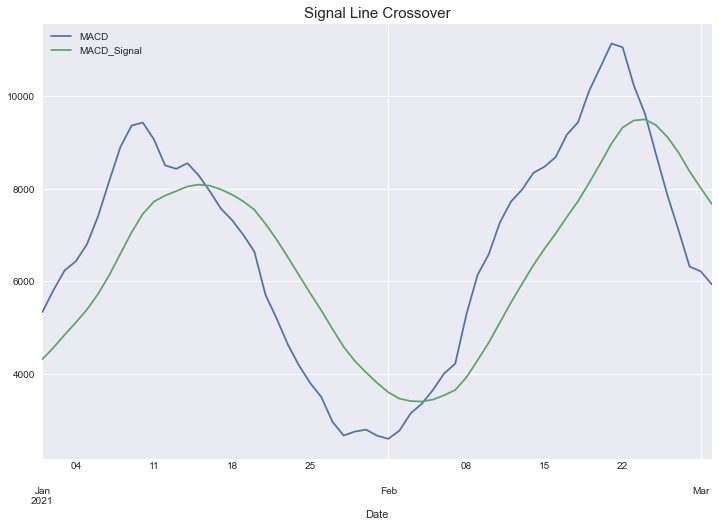

In [36]:
alt.loc["2021", ["MACD", "MACD_Signal"]].plot(figsize = (12, 8))
#plt.hlines(y = 0, xmin = alt.index[0], xmax = alt.index[-1], color = "r", label = "Zero")
plt.title("Signal Line Crossover", fontsize = 15)
plt.legend()
plt.show()

__Alternative 1: Zero Crossover__

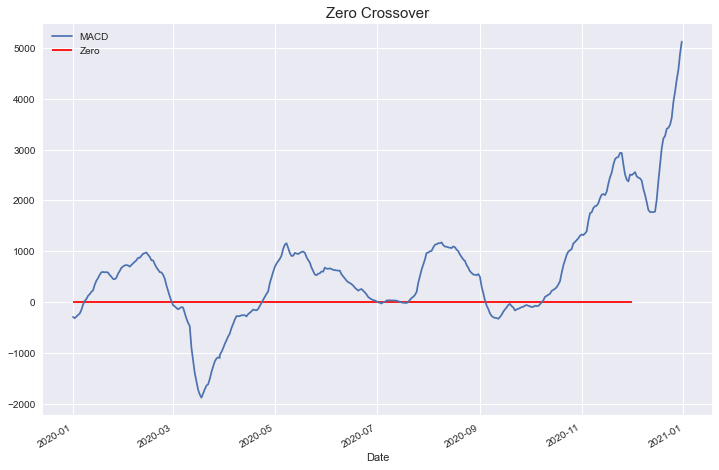

In [47]:
alt.loc["2020","MACD"].plot(figsize = (12, 8))
plt.hlines(y = 0, xmin = '2020-01', xmax = '2020-12', color = "r", label = "Zero")
plt.title("Zero Crossover", fontsize = 15)
plt.legend()
plt.show()

__Alternative 2: Divergence__

Convergence: 
- if __Price__ reaches __higher highs__ -> __MACD__ reaches __higher highs__ (confirmation)
- if __Price__ reaches __lower lows__ -> __MACD__ reaches __lower lows__ (confirmation) 

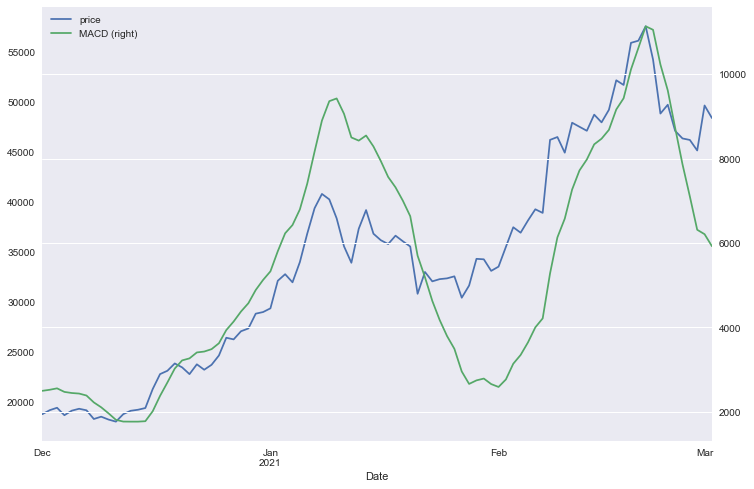

In [38]:
alt.loc["12-2020":"03-2021", ["price", "MACD"]].plot(figsize = (12, 8), secondary_y = "MACD")
plt.show()

Divergence: 
- if __Price__ reaches __higher highs__ -> __MACD fails__ to reach higher highs (__Bearish Divergence__)
- if __Price__ reaches __lower lows__ -> __MACD fails__ to reach lower lows (__Bullish Divergence__)

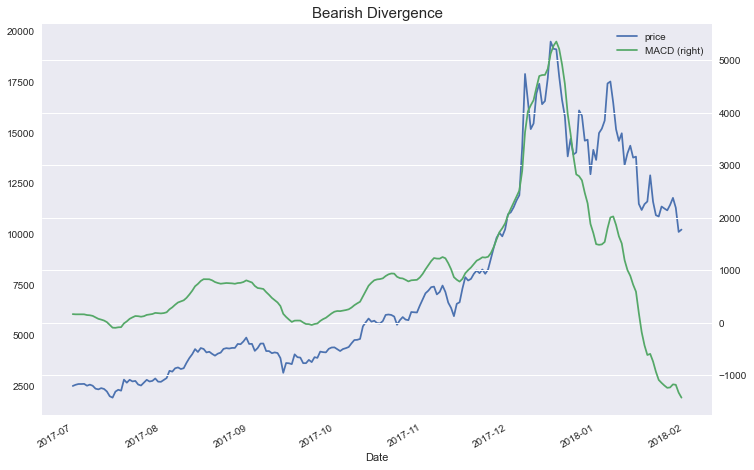

In [39]:
alt.loc["07-2017":"01-2018", ["price", "MACD"]].plot(figsize = (12, 8), secondary_y = "MACD")
plt.title("Bearish Divergence", fontsize = 15)
plt.show()

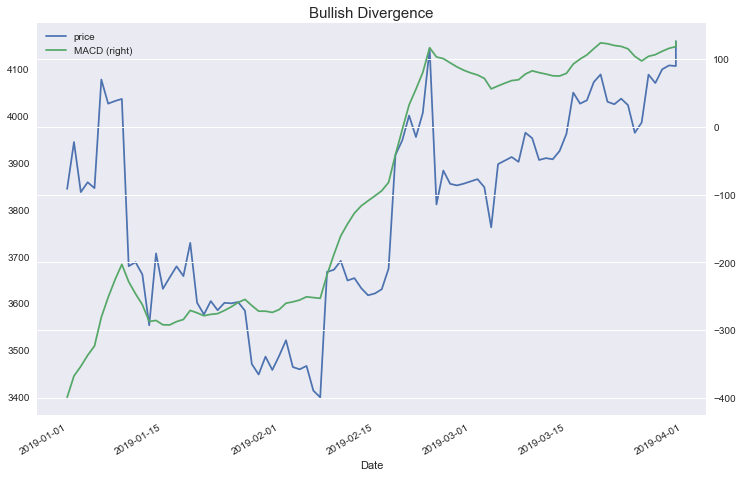

In [40]:
alt.loc["01-2019":"03-2019", ["price", "MACD"]].plot(figsize = (12, 8), secondary_y = "MACD")
plt.title("Bullish Divergence", fontsize = 15)
plt.show()